# Import

In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import glob
import seaborn as sns
from torchviz import make_dot, make_dot_from_trace
from skimage import io, transform
from torch import tensor
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
import sys
sys.path.insert(0, '/home/krishna/deeplearning-localization')
from input_output import Default
from utility import Utility
from torch._six import container_abcs, string_classes, int_classes
import re
np_str_obj_array_pattern = re.compile(r'[SaUO]')
default_collate_err_msg_format = (
    "default_collate: batch must contain tensors, numpy arrays, numbers, "
    "dicts or lists; found {}")


# 1 Common modules

In [2]:
class Normalize:
    '''
    '''
    def __init__(self, noise_floor):
        self.noise_floor = noise_floor

    def __call__(self, matrix):
        matrix -= self.noise_floor
        max_value = max([max(l) for l in matrix])
        matrix /= (max_value)
        return matrix.astype(np.float32)

class Metrics:
    '''Evaluation metrics
    '''

    @staticmethod
    def localization_error_regression(pred_batch, truth_batch, debug=False):
        '''euclidian error when modeling the output representation is a matrix (image)
           both pred and truth are batches, typically a batch of 32
        '''
        error = []
        for pred, truth in zip(pred_batch, truth_batch):
            error_row = []
            for i in range(0, len(pred), 2):
                one = pred[i:i+2] - truth[i:i+2]   # one pair of predicted location and ground truth
                error_row.append(np.sqrt(np.dot(one, one)))
            error.append(np.mean(error_row))
            if debug:
                print('pred', pred, 'truth', truth, 'err', error)
        return error
    
    @staticmethod
    def loss(pred, y):
        n = len(pred) * len(pred[0])
        summ = np.sum((pred - y)**2)
        return summ/n

In [3]:
def my_padding(batch, max_len):
    """add zeros to elements that are not maximum length"""
    for i in range(len(batch)):
        diff = max_len - len(batch[i])
        if diff > 0:                      # padding
            zeros = torch.zeros(diff)
            padded = torch.cat((batch[i], zeros), 0)
            batch[i] = padded

def my_collate(batch):
    """Puts each data field into a tensor with outer dimension batch size"""
    elem = batch[0]
    elem_type = type(elem)
    if isinstance(elem, torch.Tensor):
        max_len = len(max(batch, key=len))
        min_len = len(min(batch, key=len))
        if max_len != min_len:
            my_padding(batch, max_len)
        out = None
        if torch.utils.data.get_worker_info() is not None:
            # If we're in a background process, concatenate directly into a
            # shared memory tensor to avoid an extra copy
            numel = sum([x.numel() for x in batch])
            storage = elem.storage()._new_shared(numel)
            out = elem.new(storage)
        return torch.stack(batch, 0, out=out)
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' \
            and elem_type.__name__ != 'string_':
        if elem_type.__name__ == 'ndarray' or elem_type.__name__ == 'memmap':
            # array of string classes and object
            if np_str_obj_array_pattern.search(elem.dtype.str) is not None:
                raise TypeError(default_collate_err_msg_format.format(elem.dtype))

            return my_collate([torch.as_tensor(b) for b in batch])
        elif elem.shape == ():  # scalars
            return torch.as_tensor(batch)
    elif isinstance(elem, float):
        return torch.tensor(batch, dtype=torch.float64)
    elif isinstance(elem, int_classes):
        return torch.tensor(batch)
    elif isinstance(elem, string_classes):
        return batch
    elif isinstance(elem, container_abcs.Mapping):
        return {key: my_collate([d[key] for d in batch]) for key in elem}
    elif isinstance(elem, tuple) and hasattr(elem, '_fields'):  # namedtuple
        return elem_type(*(my_collate(samples) for samples in zip(*batch)))
    elif isinstance(elem, container_abcs.Sequence):
        # check to make sure that the elements in batch have consistent size
        it = iter(batch)
        elem_size = len(next(it))
        if not all(len(elem) == elem_size for elem in it):
            raise RuntimeError('each element in list of batch should be of equal size')
        transposed = zip(*batch)
        return [my_collate(samples) for samples in transposed]

    raise TypeError(default_collate_err_msg_format.format(elem_type))


def my_uncollate(y_num, y_float):
    """this is for uncollating the target_float"""
    y_float_tmp = []
    for ntx, y_f in zip(y_num, y_float):
        y_float_tmp.append(y_f[:ntx*2])
    return np.array(y_float_tmp)

# 2 Dataset

## Dataset & Dataloader

In [4]:
class SensorInputDatasetRegression(Dataset):
    '''Sensor reading input dataset -- for multi TX
       Output is image, model as a image segmentation problem
    '''
    def __init__(self, root_dir: str, grid_len:int, transform=None):
        '''
        Args:
            root_dir:  directory with all the images
            labels:    labels of images
            transform: optional transform to be applied on a sample
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))
        self.sample_per_label = self.get_sample_per_label()
        self.grid_len = grid_len

    def __len__(self):
        return self.length * self.sample_per_label

    def __getitem__(self, idx):
        folder = int(idx/self.sample_per_label)
        folder = format(folder, '06d')
        matrix_name = str(idx%self.sample_per_label) + '.npy'
        matrix_path = os.path.join(self.root_dir, folder, matrix_name)
        target_name = str(idx%self.sample_per_label) + '.target.npy'
        target_arr = self.get_regression_target(folder, target_name)
        target_num = int(len(target_arr)/2)
        matrix = np.load(matrix_path)
        if self.transform:
            matrix = self.transform(matrix)
        target_arr = self.min_max_normalize(target_arr)
        sample = {'matrix': matrix, 'target': target_arr, 'target_num': target_num, 'index': idx}
        return sample

    def get_sample_per_label(self):
        folder = glob.glob(os.path.join(self.root_dir, '*'))[0]
        samples = glob.glob(os.path.join(folder, '*.npy'))
        targets = glob.glob(os.path.join(folder, '*.target.npy'))
        return len(samples) - len(targets)

    def get_regression_target(self, folder: str, target_name: str):
        '''
        Args:
            folder: example of folder is 000001
        Return:
            a two dimension matrix
        '''
        target_file = os.path.join(self.root_dir, folder, target_name)
        target = np.load(target_file)
        target = np.reshape(target, -1)
        return target.astype(np.float32)

    def min_max_normalize(self, target_arr: np.ndarray):
        '''scale the localization to a range of (0, 1)
        '''
        target_arr /= Default.grid_length
        return target_arr

    def undo_normalize(self, arr: np.ndarray):
        arr *= self.grid_len
        return arr


tf = T.Compose([
     Normalize(Default.noise_floor_ipsn),
     T.ToTensor()])



In [5]:
root_dir = 'ipsn_testbed/train_random'
# root_dir = 'data/305train'
sensor_input_dataset = SensorInputDatasetRegression(root_dir=root_dir, grid_len=Default.grid_length, transform=tf)

[0.04928758 0.05228882 0.4991504  0.70224833 0.44112995 0.85088927
 0.2646941  0.5488554 ]
4


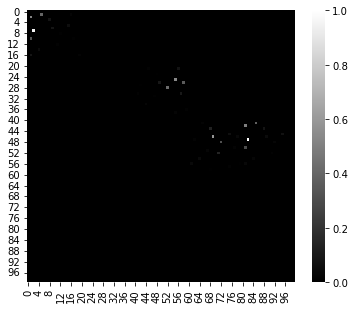

In [6]:
i = 0
mat = sensor_input_dataset[i]['matrix']
mat = mat.data.numpy()
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(mat[0], cmap='gray')

target = sensor_input_dataset[i]['target']
print(target)
target_num = sensor_input_dataset[i]['target_num']
print(target_num)

In [7]:
# training
i = 0
root_dir = 'ipsn_testbed/train_random'
# root_dir = 'data/305train'
sensor_input_dataset = SensorInputDatasetRegression(root_dir=root_dir, grid_len=Default.grid_length, transform=tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=32, shuffle=True, num_workers=1, collate_fn=my_collate)
print('matrix shape:', sensor_input_dataset[i]['matrix'].shape)
print('matrix shape:', sensor_input_dataset[i]['matrix'])
print('target:', sensor_input_dataset[i]['target'])
print('length:', sensor_input_dataset.__len__())

print('---\n')
# testing
root_dir = 'ipsn_testbed/test_random'
# root_dir = 'data/305test'
sensor_input_test_dataset = SensorInputDatasetRegression(root_dir=root_dir, grid_len=Default.grid_length, transform=tf)
sensor_input_test_dataloader = DataLoader(sensor_input_test_dataset, batch_size=32, shuffle=True, num_workers=1, collate_fn=my_collate)
print('matrix type:', sensor_input_test_dataset[i]['matrix'].dtype)
print('target type:', sensor_input_test_dataset[i]['target'].dtype)
print('target num:', sensor_input_test_dataset[i]['target_num'])
print(sensor_input_test_dataset.__len__())

matrix shape: torch.Size([1, 100, 100])
matrix shape: tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.5181, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])
target: [0.04928758 0.05228882 0.4991504  0.70224833 0.44112995 0.85088927
 0.2646941  0.5488554 ]
length: 18000
---

matrix type: torch.float32
target type: float32
target num: 4
9000


# 3 Model

In [8]:
class CNN_NoTx(nn.Module):
    """this CNN predicts # of TX """
    
    def __init__(self, max_ntx):
        super(CNN_NoTx, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3))
        self.conv4 = nn.Conv2d(128, 128, kernel_size=(3, 3))
        self.flat = nn.Flatten()
        self.drop = nn.Dropout(p=0.5)
        self.dense = nn.Linear(8192, 512)
        self.dense1 = nn.Linear(512, max_ntx)
#         self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.relu(self.conv4(x))
#         x = x.view(-1, self.num_flat_features(x))
        x = self.flat(x)
        x = self.drop(x)
        x = F.relu(self.dense(x))
        x = self.dense1(x)
#         x = self.softmax(self.dense1(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


numtx = CNN_NoTx(max_ntx=10)
print(numtx)

CNN_NoTx(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (drop): Dropout(p=0.5, inplace=False)
  (dense): Linear(in_features=8192, out_features=512, bias=True)
  (dense1): Linear(in_features=512, out_features=10, bias=True)
)


## Utility

In [9]:
def make_zeros(batch=32, length=100):
    '''for the regulation in the loss function
    '''
    zeros = []
    for _ in range(batch):
        zero = np.zeros((length, length))
        zero = np.expand_dims(zero, 0)
        zeros.append(zero)
    return torch.as_tensor(zeros).to(torch.device('cuda'))

def plot_epochs(train_losses1, test_losses1, train_errors1, test_errors1):
    print('train loss of num of TX   =', np.mean(train_losses1))
    print('test  loss of num of TX   =', np.mean(test_losses1))
    print('train error of num of TX  =', np.mean(train_errors1))
    print('test error of num of TX   =', np.mean(test_errors1))
    train_losses2_epoch.append((np.mean(train_losses1)))
    train_errors2_epoch.append((np.mean(train_errors1)))
    test_losses2_epoch.append((np.mean(test_losses1)))
    test_errors2_epoch.append((np.mean(test_errors1)))
    clear_output(True)
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(train_losses2_epoch, label='Train', linewidth=5)
    plt.plot(test_losses2_epoch, label='Test', linewidth=5)
    plt.legend(fontsize=30)
    plt.subplot(1, 2, 2)
    plt.title('Error (1-accuracy)', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(train_errors2_epoch, label='Train', linewidth=5)
    plt.plot(test_errors2_epoch, label='Test', linewidth=5)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()

# Training

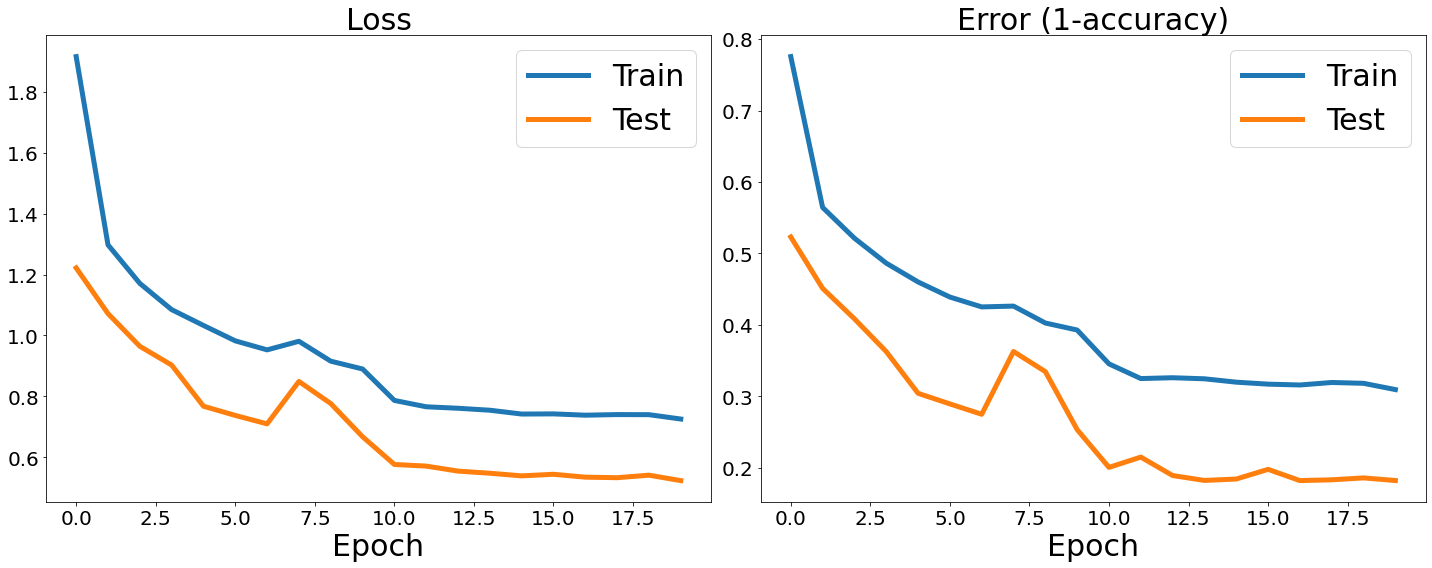

In [10]:
# path2 = 'model/model2-11.17.pt'
model1_minloss = 1000
path1 = 'model_dtxf/2.28-cnn1.pt'

max_ntx    = 10
device     = torch.device('cuda')
model1     = CNN_NoTx(max_ntx)
model1     = model1.to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
cross_entro_loss = nn.CrossEntropyLoss()
scheduler  = optim.lr_scheduler.StepLR(optimizer1, step_size=10, gamma=0.1)

num_epochs = 20
train_losses2_epoch = []
train_errors2_epoch = []
test_losses2_epoch  = []
test_errors2_epoch  = []
test_num_tx = []
print_every, error_every = 100, 1

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses, train_errors = [], []
    test_losses, test_errors   = [], []
    test_num_tx = []
    model1.train()
    for t, sample in enumerate(sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_num   = sample['target_num'].to(device)
        y_num2  = np.array(sample['target_num'])
        indx = sample['index']

        pred_ntx = model1(X)              # the model for num TX
        loss1 = cross_entro_loss(pred_ntx, y_num-1)  # 1 TX is class 0, 2 TX is class 1
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()

        train_losses.append(loss1.item())
        _, pred_ntx = pred_ntx.data.cpu().max(1)
        pred_ntx = (pred_ntx + 1).numpy()    # class 0 means 1 TX, class 1 means 2 TX etc...
        if t % error_every == 0:
            ntx_correct = (pred_ntx == y_num2).sum()
            total = len(pred_ntx)
            train_errors.append(1 - ntx_correct / total)
        if t % print_every == 0:
            print(f't = {t}, loss_num_tx = {loss1.item()},')

    model1.eval()
    for t, sample in enumerate(sensor_input_test_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_num   = sample['target_num'].to(device)
        y_num2  = np.array(sample['target_num'])
        indx = sample['index']

        pred_ntx    = model1(X)              # the model for num TX
        loss1 = cross_entro_loss(pred_ntx, y_num-1)  # 1 TX is class 0, 2 TX is class 1

        test_losses.append(loss1.item())
        _, pred_ntx = pred_ntx.data.cpu().max(1)
        pred_ntx = (pred_ntx + 1).numpy()    # class 0 means 1 TX, class 1 means 2 TX etc...
        if t % error_every == 0:
            test_num_tx.extend(list(y_num2))
            ntx_correct = (pred_ntx == y_num2).sum()
            total = len(pred_ntx)
            test_errors.append(1 - ntx_correct * 1.0 / total)

    if np.mean(test_losses) < model1_minloss:
        torch.save(model1.state_dict(), path1)
        model1_minloss = np.mean(test_losses)

    scheduler.step()

    print('train loss of num of TX   =', np.mean(train_losses))
    print('test  loss of num of TX   =', np.mean(test_losses))
    print('train error of num of TX  =', np.mean(train_errors))
    print('test error of num of TX   =', np.mean(test_errors))
    train_losses2_epoch.append((np.mean(train_losses)))
    train_errors2_epoch.append((np.mean(train_errors)))
    test_losses2_epoch.append((np.mean(test_losses)))
    test_errors2_epoch.append((np.mean(test_errors)))
    clear_output(True)
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(train_losses2_epoch, label='Train', linewidth=5)
    plt.plot(test_losses2_epoch, label='Test', linewidth=5)
    plt.legend(fontsize=30)
    plt.subplot(1, 2, 2)
    plt.title('Error (1-accuracy)', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(train_errors2_epoch, label='Train', linewidth=5)
    plt.plot(test_errors2_epoch, label='Test', linewidth=5)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()


In [73]:
model1.eval()
for t, sample in enumerate(sensor_input_test_dataloader):
    X = sample['matrix'].to(device)
    y = sample['target'].to(device)
    y_num   = sample['target_num'].to(device)
    y_num2  = np.array(sample['target_num'])
    y_float = np.array(sample['target'])
    y_float = my_uncollate(y_num2, y_float)
    indx = sample['index']

    pred_ntx    = model1(X)              # the model for num TX
    loss1 = cross_entro_loss(pred_ntx, y_num-1)  # 1 TX is class 0, 2 TX is class 1

    test_losses.append(loss1.item())
    _, pred_ntx = pred_ntx.data.cpu().max(1)
    pred_ntx = (pred_ntx + 1).numpy()    # class 0 means 1 TX, class 1 means 2 TX etc...
    test_num_tx.extend(list(y_num2))
    ntx_correct = (pred_ntx == y_num2).sum()
    total = len(pred_ntx)
    for p, y, d in zip(pred_ntx, y_num2, pred_ntx-y_num2):
        print(p, y, d)
    print('error', 1 - ntx_correct * 1.0 / total)
    break

7 7 0
5 5 0
8 9 -1
8 8 0
1 1 0
10 10 0
7 8 -1
2 2 0
4 4 0
5 5 0
9 10 -1
1 1 0
8 8 0
3 3 0
6 6 0
7 8 -1
4 4 0
1 1 0
5 5 0
1 1 0
3 3 0
2 2 0
6 6 0
1 1 0
2 2 0
3 3 0
7 9 -2
4 4 0
10 10 0
2 2 0
8 8 0
3 3 0
error 0.15625


/tmp/ipykernel_15069/687672190.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(y_float_tmp)


## Model 2

### Utilities

In [12]:
def match(pred, y):
    '''
    Args:
        pred: Tensor -- (batch size, num tx * 2)
        y   : Tensor -- (batch size, num tx * 2)
    '''
    batch_size = len(pred)
    dimension  = len(pred[0])
    pred_m, y_m = torch.zeros((batch_size, dimension)), torch.zeros((batch_size, dimension))
    for i in range(batch_size):
        pred2, y2 = [], []   # for one sample
        for j in range(0, dimension, 2):
            pred2.append(pred[i][j:j+2])
            y2.append(y[i][j:j+2])
        pred2, y2 = match_helper(pred2, y2)
        pred_m[i] = pred2
        y_m[i]    = y2
    return pred_m, y_m

def match_helper(pred, y):
    ''' up to now, assume len(pred) and len(y) is equal
        do a matching of the predictions and truth
    Args:
        pred: list<Tensor<float>> -- pairs of locations
        y   : list<Tensor> -- pairs of locations
    Return:
        Tensor<float>, Tensor<float>
    '''
    distances = np.zeros((len(pred), len(y)))
    for i in range(len(pred)):
        for j in range(len(y)):
            distances[i, j] = Utility.distance(pred[i], y[j])

    matches = []
    k = 0
    while k < min(len(pred), len(y)):
        min_error = np.min(distances)
        min_error_index = np.argmin(distances)
        i = min_error_index // len(y)
        j = min_error_index % len(y)
        matches.append((i, j, min_error))
        distances[i, :] = np.inf
        distances[:, j] = np.inf
        k += 1

    pred_m, y_m = [], []
    for i, j, e in matches:
        pred_m.append(pred[i])
        y_m.append(y[j])

    return torch.cat(pred_m), torch.cat(y_m)

In [13]:
class CNN_i(nn.Module):

    def __init__(self, max_ntx):
        super(CNN_i, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3))
        self.conv4 = nn.Conv2d(128, 128, kernel_size=(3, 3))
        self.flat = nn.Flatten()
        self.drop = nn.Dropout(p=0.5)
        self.dense = nn.Linear(8192, 512)
        self.dense1 = nn.Linear(512,2*max_ntx)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.relu(self.conv4(x))
        x = self.flat(x)
        x = self.drop(x)
        x = F.relu(self.dense(x))
        y1 = self.dense1(x)
        return y1

In [18]:
sensor_input_train_cnn2_dataset = []
sensor_input_train_cnn2_dataloader = []
data1 = ['cnn2_train1', 'cnn2_train2', 'cnn2_train3', 'cnn2_train4', 'cnn2_train5', 'cnn2_train6', 'cnn2_train7', 'cnn2_train8', 'cnn2_train9', 'cnn2_train10']
for d in range(len(data1)):
#     root_dir = './data3/' + data1[d]
    root_dir = 'ipsn_testbed/dtxf_random/' + data1[d]
    sensor_input_dataset = SensorInputDatasetRegression(root_dir = root_dir, grid_len=Default.grid_length, transform = tf)
    sensor_input_train_cnn2_dataset.append(sensor_input_dataset)
    sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=32, shuffle=True, num_workers=3, collate_fn=my_collate)
    sensor_input_train_cnn2_dataloader.append(sensor_input_dataloader)

sensor_input_test_cnn2_dataset = []
sensor_input_test_cnn2_dataloader = []
data2 = ['cnn2_test1', 'cnn2_test2', 'cnn2_test3', 'cnn2_test4', 'cnn2_test5', 'cnn2_test6', 'cnn2_test7', 'cnn2_test8', 'cnn2_test9', 'cnn2_test10']
for d in range(len(data2)):
#     root_dir = './data3/' + data2[d]
    root_dir = 'ipsn_testbed/dtxf_random/' + data2[d]
    sensor_input_test_dataset = SensorInputDatasetRegression(root_dir = root_dir, grid_len=Default.grid_length, transform = tf)
    sensor_input_test_cnn2_dataset.append(sensor_input_test_dataset)
    sensor_input_test_dataloader = DataLoader(sensor_input_test_dataset, batch_size=32, shuffle=True, num_workers=3, collate_fn=my_collate)
    sensor_input_test_cnn2_dataloader.append(sensor_input_test_dataloader)

num tx = 6


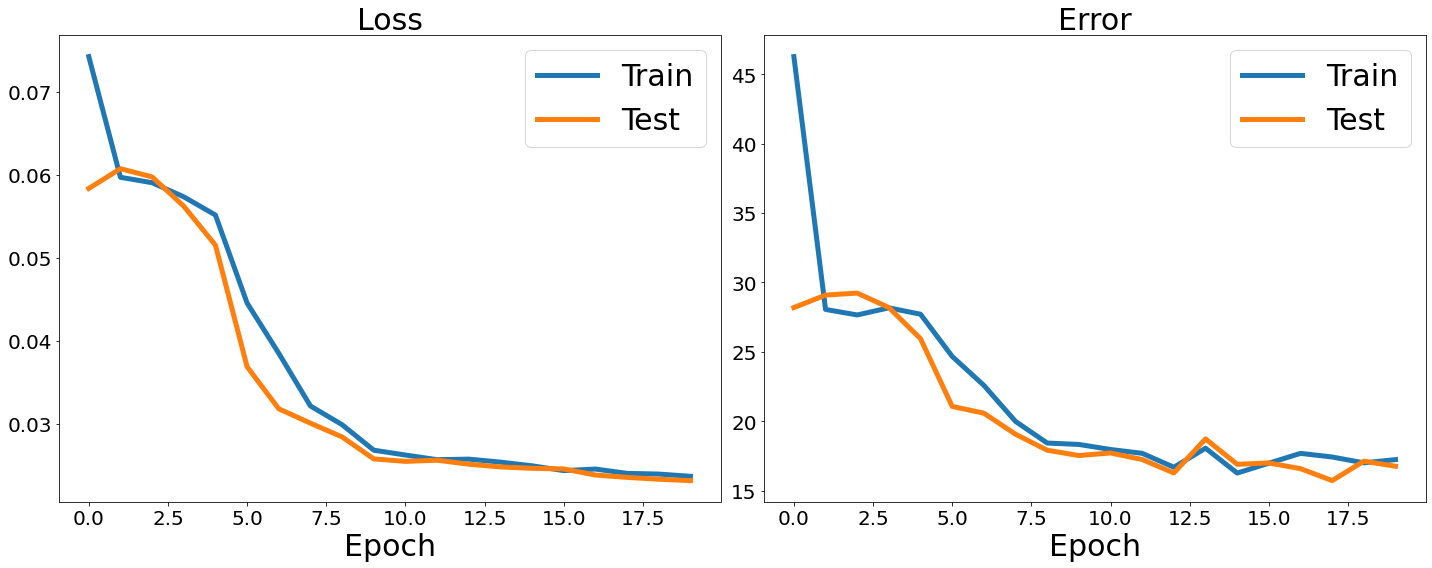

In [19]:
num_epochs = 20
max_ntx = 10
models = []
optimizers = []
schedulers = []
path = 'model_dtxf/2.28-cnn2-ipsn_{}.pt'
for i in range(1, max_ntx+1):
    net    = CNN_i(i)
    device = torch.device('cuda')
    model  = net.to(device)
    models.append(model)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    optimizers.append(optimizer)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)
    schedulers.append(scheduler)

for i in range(len(sensor_input_train_cnn2_dataloader)):
    if i >= 6:
        continue
    model1_minloss = 1000

    sensor_input_dataset         = sensor_input_train_cnn2_dataset[i]
    sensor_input_test_dataset    = sensor_input_test_cnn2_dataset[i]
    sensor_input_dataloader      = sensor_input_train_cnn2_dataloader[i]
    sensor_input_test_dataloader = sensor_input_test_cnn2_dataloader[i]
    model = models[i]
    optimizer = optimizers[i]
    scheduler = schedulers[i]

    criterion = nn.MSELoss()  # criterion is the loss function
    num_tx = i + 1
    train_losses2_epoch = []
    train_errors2_epoch = []
    test_losses2_epoch  = []
    test_errors2_epoch  = []
    print_every = 20
    error_every = 20

    for epoch in range(num_epochs):
        print(f'epoch = {epoch}')
        train_losses = []
        train_errors = []
        test_losses  = []
        test_errors  = []
        model.train()
        for t, sample in enumerate(sensor_input_dataloader):
            X = sample['matrix'].to(device)
            y = sample['target'].to(device)
            y_num   = int(sample['target_num'][0])
            if y_num != num_tx:
                raise(f"number of TX wrong! num_tx={num_tx}, y_num={y_num}")

            pred = model(X)

            pred, y = match(pred, y)

            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            pred = pred.cpu().detach().numpy()
            y    = y.cpu().detach().numpy()
            pred = sensor_input_dataset.undo_normalize(pred)
            y    = sensor_input_dataset.undo_normalize(y)
            if t % print_every == 0:
                train_errors.extend(Metrics.localization_error_regression(pred, y))
                print(f't = {t}, loss = {loss.item()}; error= {np.mean(train_errors[-32:])}')

        model.eval()
        for t, sample in enumerate(sensor_input_test_dataloader):

            X = sample['matrix'].to(device)
            y = sample['target'].to(device)
            y_num   = int(sample['target_num'][0])
            if y_num != num_tx:
                raise(f"number of TX wrong! num_tx={num_tx}, y_num={y_num}")

            pred = model(X)
            pred, y = match(pred, y)

            loss = criterion(pred, y)
            test_losses.append(loss.item())
            pred = pred.cpu().detach().numpy()
            y    = y.cpu().detach().numpy()
            pred = sensor_input_test_dataset.undo_normalize(pred)
            y    = sensor_input_test_dataset.undo_normalize(y)
            if t % print_every == 0:
                test_errors.extend(Metrics.localization_error_regression(pred, y))
                print(f't = {t}, loss = {loss.item()}; error= {np.mean(test_errors[-32:])}')


        if np.mean(test_losses) < model1_minloss:
            torch.save(model.state_dict(), path.format(num_tx))
            model1_minloss = np.mean(test_losses)

        scheduler.step()
        print('train loss of num of TX   =', np.mean(train_losses))
        print('test  loss of num of TX   =', np.mean(test_losses))
        print('train error of num of TX  =', np.mean(train_errors))
        print('test error of num of TX   =', np.mean(test_errors))
        train_losses2_epoch.append((np.mean(train_losses)))
        train_errors2_epoch.append((np.mean(train_errors)))
        test_losses2_epoch.append((np.mean(test_losses)))
        test_errors2_epoch.append((np.mean(test_errors)))
        clear_output(True)
        print(f'num tx = {num_tx}')
        plt.figure(figsize=(20, 8))
        plt.subplot(1, 2, 1)
        plt.title('Loss', fontsize=30)
        plt.xlabel('Epoch', fontsize=30)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.plot(train_losses2_epoch, label='Train', linewidth=5)
        plt.plot(test_losses2_epoch, label='Test', linewidth=5)
        plt.legend(fontsize=30)
        plt.subplot(1, 2, 2)
        plt.title('Error', fontsize=30)
        plt.xlabel('Epoch', fontsize=30)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.plot(train_errors2_epoch, label='Train', linewidth=5)
        plt.plot(test_errors2_epoch, label='Test', linewidth=5)
        plt.legend(fontsize=30)
        plt.tight_layout()
        if epoch == num_epochs - 1:
            plt.savefig(f'model_dtxf/2.28-cnn2_{num_tx}.png')
        plt.show()

